In [1]:
# !pip install geopandas
# !pip install pygeos
# !pip install rtree
# !pip install geopy
# !pip install matplotlib

     |████████████████████████████████| 1.0MB 8.1MB/s 
     |████████████████████████████████| 6.5MB 18.3MB/s 
     |████████████████████████████████| 14.8MB 327kB/s 
     |████████████████████████████████| 2.1MB 9.3MB/s 
     |████████████████████████████████| 1.0MB 8.4MB/s 


In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
import geopandas as gpd
from shapely.geometry import Point, LineString, MultiPoint
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopy

/Users/garyzhu/anaconda3/lib/python3.6/site-packages/geopandas/_compat.py:110: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.9.0-CAPI-1.16.2). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


In [2]:
def join_reducer(left, right):
    """
    Take two geodataframes, do a spatial join, and return 
    without the index_left and index_right columns
    """
    sjoin = gpd.sjoin(left, right, how='inner')
    for column in ['index_left', 'index_right']:
        try:
            sjoin.drop(column, axis=1, inplace=True)
        except Exception as e:
            # ignore if there are no index columns
            pass
    
    return sjoin

In [3]:
# Function to generate random points and lines on roads

# Source: https://github.com/gboeing/osmnx/issues/639

def sample_roads(geodf, n=100, isLine=False):
  '''
  Sample points and lines(street segments) from a road network
  '''
  m = len(geodf)
  lengths = geodf['LENGTH'].tolist()
  total_length = geodf.sum()['LENGTH']
  lengths_normalized = [l/total_length for l in lengths] 

  indices = np.random.choice(range(m), size=n, p=lengths_normalized)

  if isLine:
    lines = []
    for index in indices:
      line = geodf.iloc[index]['geometry']
      lines.append(line)
  
    # return MultiPoint(lines)
    return gpd.GeoSeries(lines)
  
  points = []
  for index in indices:
      line = geodf.iloc[index]['geometry']
      offset = np.random.rand() * line.length
      point = line.interpolate(offset)
      points.append(point)
      
  # return MultiPoint(points)
  return gpd.GeoSeries(points)

In [4]:
def sample_location(geodf, n, buffer=None):
  '''
  Samples from a shapefile that has 
  ALL entries as point geometries
  '''
  m = len(geodf)
  indices = np.random.choice(range(m), size=n)
  sample = []

  for index in indices:
    point = geodf.iloc[index]['geometry']
    sample.append(point)

  output = gpd.GeoSeries(sample)
  if buffer:
    output.set_crs('EPSG:4326', inplace=True)
    output = output.to_crs(epsg=3763)
    output = output.buffer(buffer)
    output = output.to_crs(epsg=4326)
  return output

In [5]:
def reverse_geocode(geoseries, provider='arcgis'):
  '''
  Function to reverse geocode GeoSeries points
  '''
  return gpd.tools.reverse_geocode(list(geoseries), provider=provider)

In [6]:
def geoseries_to_geodf(geoseries):
  '''
  Converts a simple GeoSeries to a GeoPandas dataframe with a geometry column
  '''
  output_gdf = gpd.GeoDataFrame(geoseries)
  output_gdf.rename(columns={0:'geometry'}).set_geometry('geometry')
  return output_gdf

# Sample Points and Lines

## Road Network x County (Boundary)

In [7]:
fl_roads = gpd.read_file("./data/majrds_oct19/majrds_oct19.shp") # LINESTRING geometry
fl_roads = fl_roads.to_crs("EPSG:4326")

DriverError: /content/drive/My Drive/IEOR 180/data/majrds_oct19/majrds_oct19.shp: No such file or directory

In [11]:
fl_counties = gpd.read_file("./data/cntbnd_sep15/cntbnd_sep15.shp") # POLYGON geometry
fl_counties = fl_counties.to_crs("EPSG:4326")

In [12]:
fl_hil = fl_counties[fl_counties['TIGERNAME'] == 'Hillsborough'] 

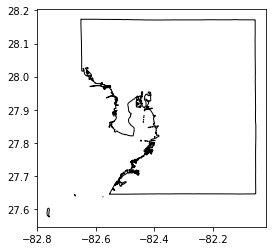

In [13]:
fl_hil.plot(facecolor="none", edgecolor="black")

In [14]:
fl_roads_hil = join_reducer(fl_roads, fl_hil) # road network MUST be left parameter when joining

In [15]:
sample_road_points = sample_roads(fl_roads_hil, n=10)

In [16]:
reverse_geocode(sample_road_points)

,geometry,address
0,POINT (-82.31450 27.92864),"660 Providence Rd, Brandon, Florida 33511, USA"
1,POINT (-82.35260 27.99666),"Eureka Springs Rd, Tampa, Florida 33610, USA"
2,POINT (-82.67220 27.64391),"I-275 S, Saint Petersburg, Florida 33715, USA"
3,POINT (-82.16655 28.04711),"4096 Sam Allen Rd W, Plant City, Florida 33565..."
4,POINT (-82.35327 27.94946),"E Adamo Dr, Tampa, Florida 33619, USA"
5,POINT (-82.15977 28.07626),"3489 Knights Griffin Rd W, Plant City, Florida..."
6,POINT (-82.36582 27.94071),"8005 Palm River Rd, Tampa, Florida 33619, USA"
7,POINT (-82.09479 28.03695),"I-4 W, Plant City, Florida 33565, USA"
8,POINT (-82.38439 27.71412),"I-75 S, Ruskin, Florida 33570, USA"
9,POINT (-82.33184 27.92855),"Exit 254, Tampa, Florida 33619, USA"


In [17]:
# ax = fl_hil.plot(figsize=(14,12), facecolor="none", edgecolor="black")
# fl_roads_hil.plot(ax=ax)
# sample_road_points.plot(marker='*', color='red', markersize=12, ax=ax)

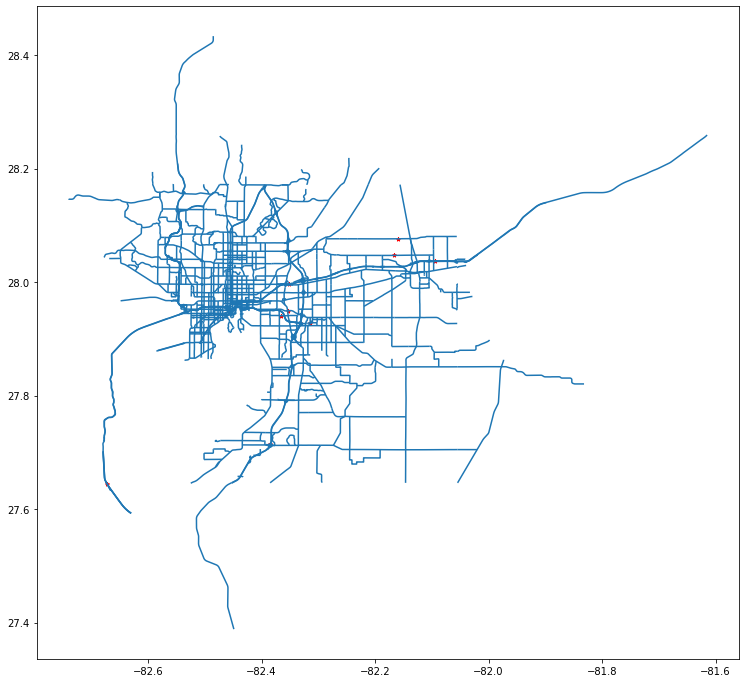

In [18]:
ax = fl_roads_hil.plot(figsize=(14, 12))
sample_road_points.plot(marker='*', color='red', markersize=15, ax=ax)

In [19]:
sample_road_lines = sample_roads(fl_roads_hil, n=10, isLine=True)
sample_road_lines

0    LINESTRING (-82.50631 27.89364, -82.50626 27.8...
1    LINESTRING (-82.58281 28.04441, -82.58268 28.0...
2    LINESTRING (-82.43075 27.73519, -82.43060 27.7...
3    LINESTRING (-82.45940 28.05464, -82.45917 28.0...
4    LINESTRING (-82.29803 27.82146, -82.29808 27.8...
5    LINESTRING (-82.05595 28.03693, -82.05681 28.0...
6    LINESTRING (-82.05595 28.03693, -82.05681 28.0...
7    LINESTRING (-82.64856 28.03361, -82.64635 28.0...
8    LINESTRING (-82.10902 28.00747, -82.10905 28.0...
9    LINESTRING (-82.05564 27.97084, -82.05556 27.9...
dtype: geometry

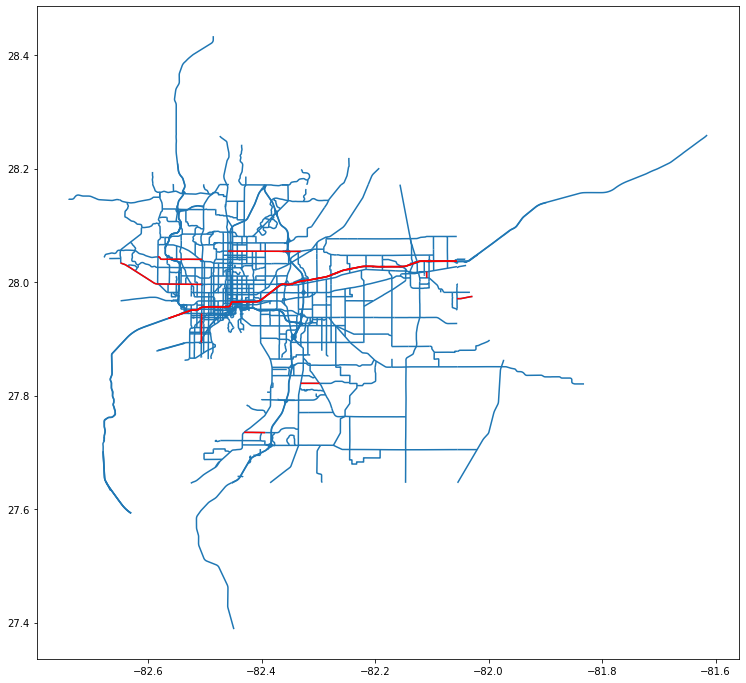

In [20]:
ax = fl_roads_hil.plot(figsize=(14, 12))
sample_road_lines.plot(color='red', ax=ax)

## Road Network x County x Parks & Rec (Boundary)

In [8]:
fl_parks = gpd.read_file("./data/gc_parksbnd_oct19/gc_parksbnd_oct19.shp") # POLYGON geometry
fl_parks = fl_parks.to_crs("EPSG:4326")

In [57]:
fl_parks.head()

,PARCELID,NAME,ADDRESS,CITY,ZIPCODE,COUNTY,TYPE,POOL,BOATRAMPID,NPSSITE_ID,ST_PARK_ID,OWNER,OPERATING,OP_CLASS,WEB_LINK,FSOURCE,DATASOURCE,LAT_DD,LONG_DD,MGRS,GOOGLEMAP,GCID,ACRES,DESCRIPT,FLAG,UPDATE_DAY,FGDLAQDATE,AUTOID,SHAPE_AREA,SHAPE_LEN,geometry
0,0711317085010100010,MALA COMPRA PARK,115 MALA COMPRA RD,PALM COAST,32137,FLAGLER,NATURE PARK / BEACH ACCESS,0.0,None,None,None,FLAGLER COUNTY,COUNTY,PUBLIC,None,FLAGLER COUNTY,FLAGLER_PARKS_POLY,29.616102,-81.190831,17RMN8152476263,https://www.google.com/maps/place/17RMN8152476263,378,55.688,MALA COMPRA PARK,V,2012-02-02,2019-10-01,1,2.253633e+05,2814.050447,"POLYGON ((-81.18918 29.61508, -81.18781 29.611..."
1,0711317085010100030,JUNGLE HUT ROAD PARK,101 JUNGLE HUT RD,PALM COAST,32137,FLAGLER,NATURE PARK / BEACH ACCESS,0.0,None,None,None,FLAGLER COUNTY,COUNTY,PUBLIC,None,FLAGLER COUNTY,FLAGLER_PARKS_POLY,29.584704,-81.177356,17RMN8282472782,https://www.google.com/maps/place/17RMN8282472782,380,3.017,JUNGLE HUT ROAD PARK,V,2016-06-17,2019-10-01,2,1.221121e+04,503.747953,"POLYGON ((-81.17634 29.58453, -81.17705 29.584..."
2,2211310000020200020,GRAND HAVEN PARK,COLBERT LN,PALM COAST,32137,FLAGLER,NATURE PARK,0.0,None,None,None,FLAGLER COUNTY,COUNTY,PUBLIC,None,FLAGLER COUNTY,FLAGLER_PARKS_POLY,29.529343,-81.171267,17RMN8340466647,https://www.google.com/maps/place/17RMN8340466647,381,48.456,GRAND HAVEN PARK,V,2015-04-27,2019-10-01,3,1.960954e+05,3547.189040,"POLYGON ((-81.17150 29.53422, -81.17085 29.533..."
3,1312310000010400000,MOODY BOAT LAUNCH / FLAGSHIP HARBOR PRESERVE /...,MOODY BLVD,FLAGLER BEACH,32136,FLAGLER,NATURE PARK / BOAT RAMP,0.0,FL00476LB,None,None,FLAGLER COUNTY,COUNTY,PUBLIC,https://public.myfwc.com/LE/boatramp/public/Ra...,FLAGLER COUNTY,FLAGLER_PARKS_POLY,29.468098,-81.129309,17RMN8746259856,https://www.google.com/maps/place/17RMN8746259856,382,334.252,MOODY BOAT LAUNCH / FLAGSHIP HARBOR PRESERVE /...,V,2012-02-02,2019-10-01,4,1.352668e+06,6935.818014,"POLYGON ((-81.13049 29.47836, -81.12950 29.476..."
4,292529470000011130,OREN BROWN PARK,3511 BAKER DR,KISSIMMEE,34741,OSCEOLA,NEIGHBORHOOD PARK / ATHLETIC,0.0,None,None,None,OSCEOLA COUNTY,COUNTY,PUBLIC,None,OSCEOLA COUNTY,OSCEOLA_PARKS_POLY,28.275657,-81.439013,17RMM5694527817,https://www.google.com/maps/place/17RMM5694527817,386,24.270,OREN BROWN PARK,V,2015-04-27,2019-10-01,5,9.821747e+04,1477.487279,"POLYGON ((-81.43757 28.27524, -81.43758 28.275..."


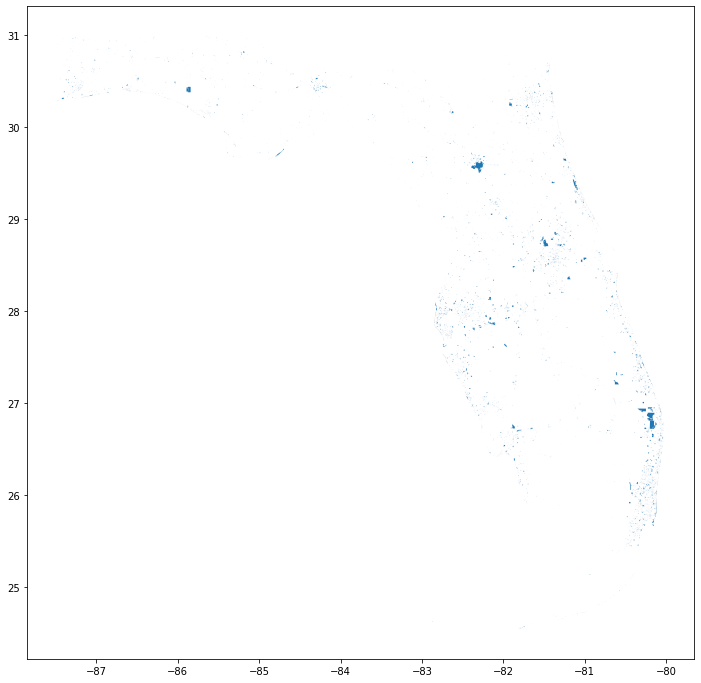

In [58]:
fl_parks.plot(figsize=(14, 12))

In [59]:
fl_hil_parks = fl_parks[fl_parks['COUNTY'] == 'HILLSBOROUGH']

In [60]:
fl_roads_hil_parks = join_reducer(fl_roads, fl_hil_parks)

In [61]:
fl_roads_hil_parks.head()

,ROADWAY,BEGIN_POST,END_POST,NAME_left,RD_STATUS,DESCR,ROAD_DIREC,INTERSTATE,TOLLROAD,USROUTE,STROUTE,CNTROAD,LENGTH,FUNCLASS,DESCRIPT_left,FGDLAQDATE_left,AUTOID_left,SHAPE_LEN_left,geometry,PARCELID,NAME_right,ADDRESS,CITY,ZIPCODE,COUNTY,TYPE,POOL,BOATRAMPID,NPSSITE_ID,ST_PARK_ID,OWNER,OPERATING,OP_CLASS,WEB_LINK,FSOURCE,DATASOURCE,LAT_DD,LONG_DD,MGRS,GOOGLEMAP,GCID,ACRES,DESCRIPT_right,FLAG,UPDATE_DAY,FGDLAQDATE_right,AUTOID_right,SHAPE_AREA,SHAPE_LEN_right
1622,10000381,0.000,0.039,14 ST,ACTIVE OFF EXCLUSIVE,14TH ST (ONE-WAY S),5,None,None,None,None,None,61.852422,00,ROADWAY FEATURE,2019-10-07,1675,61.852427,"LINESTRING (-82.44415 27.96408, -82.44411 27.9...",NONE,NUCCIO PARKWAY,NUCCIO PKY & E 7TH AVE,TAMPA,33605,HILLSBOROUGH,NEIGHBORHOOD PARK / OPEN SPACE,0.0,None,None,None,CITY OF TAMPA,MUNICIPALITY,PUBLIC,None,CITY OF TAMPA,CITY OF TAMPA,27.955931,-82.449002,17RLL5746493166,https://www.google.com/maps/place/17RLL5746493166,3138,4.762,NUCCIO PARKWAY,V,2016-06-17,2019-10-01,6800,19271.201342,4054.237385
2153,10000076,0.000,0.297,E 13 AVE,ACTIVE OFF EXCLUSIVE,E 13 AVE,3,None,None,None,None,None,477.546767,00,ROADWAY FEATURE,2019-10-07,2223,477.546765,"LINESTRING (-82.44423 27.96443, -82.44297 27.9...",NONE,NUCCIO PARKWAY,NUCCIO PKY & E 7TH AVE,TAMPA,33605,HILLSBOROUGH,NEIGHBORHOOD PARK / OPEN SPACE,0.0,None,None,None,CITY OF TAMPA,MUNICIPALITY,PUBLIC,None,CITY OF TAMPA,CITY OF TAMPA,27.955931,-82.449002,17RLL5746493166,https://www.google.com/maps/place/17RLL5746493166,3138,4.762,NUCCIO PARKWAY,V,2016-06-17,2019-10-01,6800,19271.201342,4054.237385
2161,10000255,0.000,1.004,14TH ST/AVENIDA REPU,ACTIVE OFF THE SHS,14TH ST SB,5,None,None,None,None,None,1612.560360,18,URBAN: MINOR COLLECTOR (FED AID),2019-10-07,2232,1612.560342,"LINESTRING (-82.44428 27.97783, -82.44428 27.9...",NONE,NUCCIO PARKWAY,NUCCIO PKY & E 7TH AVE,TAMPA,33605,HILLSBOROUGH,NEIGHBORHOOD PARK / OPEN SPACE,0.0,None,None,None,CITY OF TAMPA,MUNICIPALITY,PUBLIC,None,CITY OF TAMPA,CITY OF TAMPA,27.955931,-82.449002,17RLL5746493166,https://www.google.com/maps/place/17RLL5746493166,3138,4.762,NUCCIO PARKWAY,V,2016-06-17,2019-10-01,6800,19271.201342,4054.237385
1667,10000551,0.311,0.591,E SCOTT ST,ACTIVE OFF THE SHS,E SCOTT ST,3,None,None,None,None,None,450.032776,19,URBAN: LOCAL,2019-10-07,1721,450.032767,"LINESTRING (-82.45584 27.95638, -82.45500 27.9...",1829134YT000004000000A,PERRY HARVEY PARK,1201 N ORANGE AVE,TAMPA,33602,HILLSBOROUGH,NEIGHBORHOOD PARK / MIXED USE RECREATION,0.0,None,None,None,CITY OF TAMPA,MUNICIPALITY,PUBLIC,None,CITY OF TAMPA,CITY OF TAMPA,27.955628,-82.455290,17RLL5684593139,https://www.google.com/maps/place/17RLL5684593139,3153,9.598,PERRY HARVEY PARK,V,2015-06-09,2019-10-01,6814,38842.627805,1376.577927
3057,10900025,0.000,0.237,CENTRAL AVE,LOCAL ROADS WITH FM PROJECTS,CENTRAL AVE,1,None,None,None,None,None,383.417149,19,URBAN: LOCAL,2019-10-07,3155,383.417294,"LINESTRING (-82.45501 27.95294, -82.45501 27.9...",1829134YT000004000000A,PERRY HARVEY PARK,1201 N ORANGE AVE,TAMPA,33602,HILLSBOROUGH,NEIGHBORHOOD PARK / MIXED USE RECREATION,0.0,None,None,None,CITY OF TAMPA,MUNICIPALITY,PUBLIC,None,CITY OF TAMPA,CITY OF TAMPA,27.955628,-82.455290,17RLL5684593139,https://www.google.com/maps/place/17RLL5684593139,3153,9.598,PERRY HARVEY PARK,V,2015-06-09,2019-10-01,6814,38842.627805,1376.577927


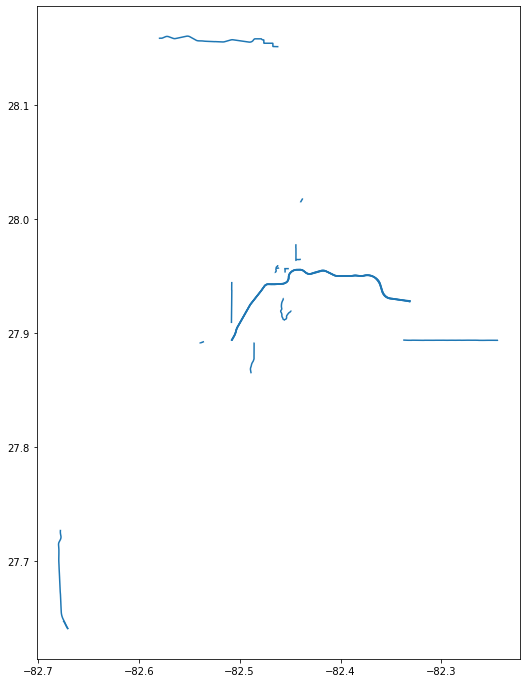

In [62]:
fl_roads_hil_parks.plot(figsize=(14,12))

In [63]:
sample_park_points = sample_roads(fl_roads_hil_parks, n=5)

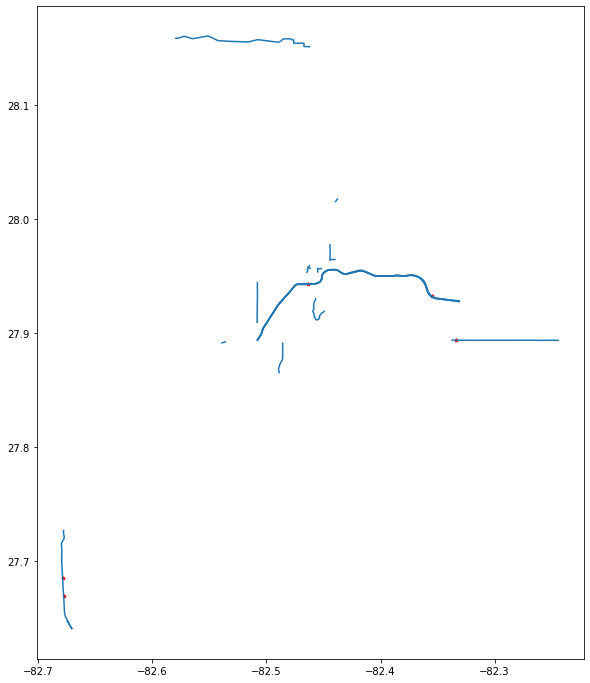

In [64]:
ax = fl_roads_hil_parks.plot(figsize=(14, 12))
sample_park_points.plot(marker='*', color='red', markersize=12, ax=ax)

In [65]:
sample_park_lines = sample_roads(fl_roads_hil_parks, n=5, isLine=True)

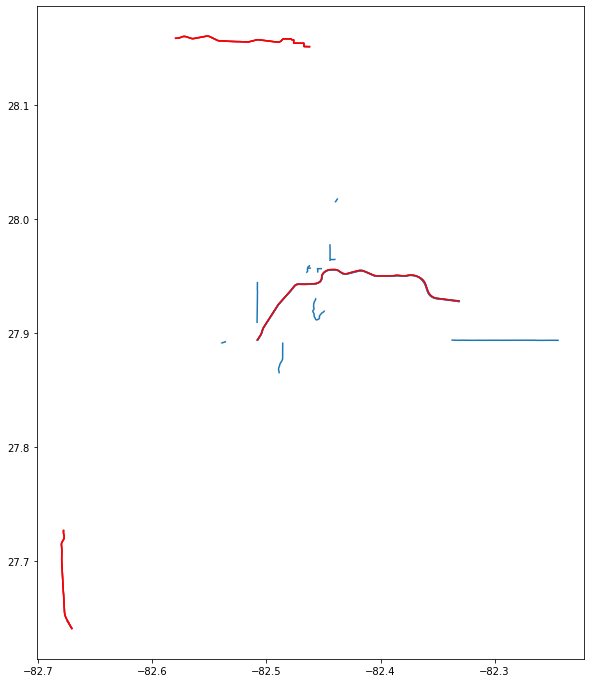

In [66]:
ax = fl_roads_hil_parks.plot(figsize=(14, 12))
sample_park_lines.plot(color='red', markersize=10, ax=ax)

## Road Network x County x Hospital (Boundaries)

In [9]:
fl_hosp = gpd.read_file("./data/gc_hospitalsbnd_sep17/gc_hospitalsbnd_sep17.shp") # POLYGON geometry
fl_hosp = fl_hosp.to_crs("EPSG:4326")

In [33]:
fl_hosp.head()

,PARCELID,FDEM_ID,NAME,ADDRESS,CITY,ZIPCODE,COUNTY,PHONE,TYPE,OWNER,OPERATING,OP_CLASS,AHCA_OWNER,PROFIT,CAPACITY,BEDS,STATE_ID,EFCLASS,AHCA_NUM,CON1_TYPE,CON1_UP,CON1_DOWN,CON2_TYPE,CON2_UP,CON2_DOWN,CON3_TYPE,CON3_UP,CON3_DOWN,NET_CONS,WEBSITE,ACTYRBLT,FSOURCE,DATASOURCE,NOTES,LAT_DD,LONG_DD,MGRS,GCID,ACRES,DESCRIPT,FLAG,UPDATE_DAY,FGDLAQDATE,AUTOID,SHAPE_AREA,SHAPE_LEN,geometry
0,32-1S-23-0000-0004-0000,N/A,96TH MEDICAL GROUP - US AIR FORCE HOSPITAL - E...,307 BOATNER RD,EGLIN AFB,32542,OKALOOSA,850-883-8600,HOSPITALS - FEDERAL,UNITED STATES OF AMERICA,FEDERAL,PUBLIC,FEDERAL GOVERNMENT,PUBLIC,0,59,N/A,EFHM,N/A,None,None,None,None,None,None,None,None,None,None,HTTP://WWW.EGLIN.AF.MIL/UNITS/EGLINHOSPITAL.ASP,0,GEOPLAN,FHA,REVIEW-CLIPPED TO ONLY HOSPITAL AREA,30.461161,-86.555096,16REU4271069972,83,61.463379,96TH MEDICAL GROUP - US AIR FORCE HOSPITAL - E...,V,2016-05-17,2017-09-06,1,248733.498992,2123.256187,"POLYGON ((-86.55617 30.46023, -86.55850 30.460..."
1,1129202120000,N/A,SELECT SPECIALTY HOSPITAL - TALLAHASSEE,1544 SURGEONS DR,TALLAHASSEE,32308,LEON,850-219-6800,HOSPITALS - ACUTE CARE,HTA-TALLAHASSEE SS HOSPITAL LL,PRIVATE,PRIVATE,SELECT MEDICAL CORPORATION,INVESTOR-OWNED,0,29,N/A,EFHS,23960059,None,None,None,None,None,None,None,None,None,None,HTTP://WWW.SELECTSPECIALTYHOSPITALS.COM/,2007,GEOPLAN,FHA,None,30.461534,-84.253070,16RGU6375073136,89,21.979975,SELECT SPECIALTY HOSPITAL - TALLAHASSEE,V,2014-04-03,2017-09-06,2,88949.803435,1193.449881,"POLYGON ((-84.25181 30.46005, -84.25499 30.459..."
2,0141140270010,N/A,SISTER EMMANUEL HOSPITAL,3663 S MIAMI AVE - 4TH FLOOR,MIAMI,33133,MIAMI-DADE,305-285-2939,HOSPITALS - ACUTE CARE,PLANTATION GENERAL HOSPITAL L,PRIVATE,PRIVATE,CATHOLIC HEALTH EAST,NOT-FOR-PROFIT,0,29,N/A,EFHS,23960044,None,None,None,None,None,None,None,None,None,None,HTTP://WWW.MERCYMIAMI.ORG/SISTER-EMMANUEL-HOSP...,1947,GEOPLAN,FHA,PARCEL CONTAINS 2 POINTS,25.742069,-80.216552,17RNJ7857847353,173,50.152685,SISTER EMMANUEL HOSPITAL,V,2016-05-17,2017-09-06,3,202960.735598,1921.221903,"POLYGON ((-80.21220 25.73971, -80.21435 25.738..."
3,74434304330020010,10053884,PALM BEACH CHILDREN'S HOSPITAL - ST. MARY'S,901 45TH ST,WEST PALM BEACH,33407,PALM BEACH,561-844-6300,HOSPITALS - CHILDREN/ACUTE CARE,TENET ST MARYS INC,PRIVATE,PRIVATE,N/A,INVESTOR-OWNED,0,81,N/A,EFHM,N/A,None,None,None,None,None,None,None,None,None,None,HTTP://WWW.STMARYSMC.COM,1938,GEOPLAN,FDEM,PARCEL CONTAINS 2 POINTS,26.755327,-80.061976,17RNK9326959680,209,81.640895,PALM BEACH CHILDREN'S HOSPITAL - ST. MARY'S,V,2016-05-17,2017-09-06,4,330388.992051,3200.247814,"POLYGON ((-80.06038 26.75950, -80.06048 26.758..."
4,52434207410010000,10224941,PALM BEACH GARDENS MEDICAL CENTER,3360 BURNS RD,PALM BEACH GARDENS,33410,PALM BEACH,561-622-1411,HOSPITALS - ACUTE CARE,HEALTH CARE PROPERTY INVESTORS,PRIVATE,PRIVATE,TENET HEALTHSYSTEM,INVESTOR-OWNED,0,199,FL000079,EFHL,100176,None,None,None,None,None,None,None,None,None,None,HTTP://WWW.PBGMC.COM/EN-US/PAGES/DEFAULT.ASPX,1964,GEOPLAN,FDEM,None,26.829589,-80.086665,17RNK9075567887,212,22.020039,PALM BEACH GARDENS MEDICAL CENTER,V,2014-09-05,2017-09-06,5,89111.946522,1185.039334,"POLYGON ((-80.08539 26.82800, -80.08719 26.827..."


In [34]:
fl_hil_hosp = fl_hosp[fl_hosp['COUNTY']=='HILLSBOROUGH']

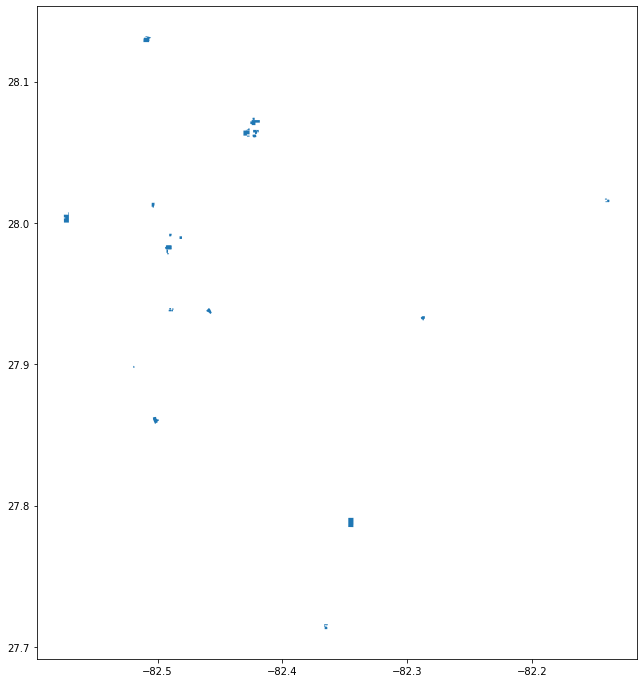

In [35]:
fl_hil_hosp.plot(figsize=(14,12))

In [36]:
fl_roads_hil_hosp = join_reducer(fl_roads, fl_hil_hosp)

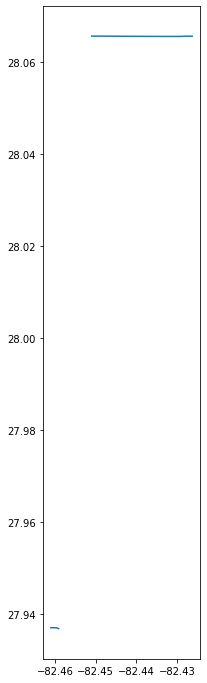

In [37]:
fl_roads_hil_hosp.plot(figsize=(14,12))

In [38]:
sample_hosp_points = sample_roads(fl_roads_hil_hosp, n=5)
sample_hosp_points

0    POINT (-82.43593 28.06554)
1    POINT (-82.44701 28.06559)
2    POINT (-82.44142 28.06556)
3    POINT (-82.44050 28.06556)
4    POINT (-82.44236 28.06556)
dtype: geometry

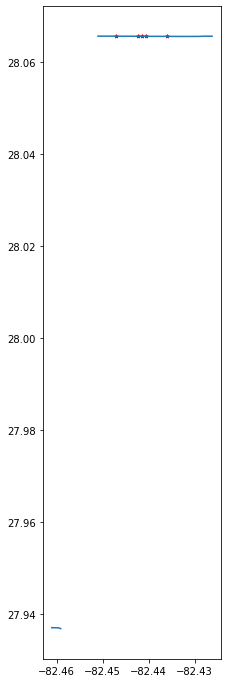

In [39]:
ax = fl_roads_hil_hosp.plot(figsize=(14, 12))
sample_hosp_points.plot(marker='*', color='red', markersize=12, ax=ax)

## Road Network x County x Civic Centers

In [10]:
fl_civic = gpd.read_file("./data/gc_civiccenter_jan19/gc_civiccenter_jan19.shp")
fl_civic = fl_civic.to_crs("EPSG:4326")

In [41]:
fl_civic.head()

,PARCELID,NAME,ADDRESS,CITY,ZIPCODE,COUNTY,TYPE,OWNER,OPERATING,OP_CLASS,CAPACITY,YR_BUILT,FSOURCE,DATASOURCE,LAT_DD,LONG_DD,MGRS,GOOGLEMAP,GCID,ACRES,DESCRIPT,FLAG,UPDATE_DAY,FGDLAQDATE,AUTOID,geometry
0,17 30 20 00000 210 0100,DERBY LANE,10490 GANDY BLVD,ST PETERSBURG,33702,PINELLAS,GREYHOUND AND/OR HORSE TRACK,ST PETERSBURG KENNEL CLUB INC,PRIVATE,PRIVATE,0,1966,GEOPLAN,GEOPLAN,27.864066,-82.627651,17RLL3975383208,https://www.google.com/maps/place/17RLL3975383208,1452,93.835,DERBY LANE,V,2018-11-15,2018-01-09,1,POINT (-82.62765 27.86407)
1,16 30 10 71010 300 0200,SUNSHINE SPEEDWAY AND DRAGSTRIP,4550 ULMERTON RD,CLEARWATER,33762,PINELLAS,SPEEDWAY,STATE OF FLORIDA,STATE,PUBLIC,0,0,GEOPLAN,GEOPLAN,27.884741,-82.690394,17RLL3360685583,https://www.google.com/maps/place/17RLL3360685583,1460,50.534,SUNSHINE SPEEDWAY AND DRAGSTRIP,V,2018-11-15,2018-01-09,2,POINT (-82.69040 27.88475)
2,16 30 04 77515 000 2101,CLEARWATER ICE ARENA (SUN BLADES ICE SKATING),13940 ICOT BLVD,CLEARWATER,33760,PINELLAS,ICE SKATING RINKS,ICEPLEX LAND ASSETS LLC,PRIVATE,PRIVATE,0,1986,GEOPLAN,GEOPLAN,27.898753,-82.716082,17RLL3109987171,https://www.google.com/maps/place/17RLL3109987171,1462,4.432,CLEARWATER ICE ARENA (SUN BLADES ICE SKATING),V,2018-11-15,2018-01-09,3,POINT (-82.71609 27.89876)
3,15 29 16 57996 000 0030,CLEARWATER CITY - HARBORVIEW CENTER,300 CLEVELAND ST,CLEARWATER,33755,PINELLAS,RECEPTION HALL,CITY OF CLEARWATER,MUNICIPALITY,PUBLIC,0,1960,GEOPLAN,GEOPLAN,27.966015,-82.801858,17RLL2276594745,https://www.google.com/maps/place/17RLL2276594745,1471,7.825,CLEARWATER CITY - HARBORVIEW CENTER,V,2018-11-15,2018-01-09,4,POINT (-82.80186 27.96602)
4,0141040100010,JOHN J KOUBEK MEMORIAL CENTER AT MIAMI-DADE CO...,2705 SW 3RD ST,MIAMI,33135,MIAMI-DADE,CIVIC CENTERS,STATE OF FLORIDA,STATE,PUBLIC,922,1929,GEOPLAN,GEOPLAN,25.769810,-80.239551,17RNJ7625350412,https://www.google.com/maps/place/17RNJ7625350412,1503,1.696,JOHN J KOUBEK MEMORIAL CENTER AT MIAMI-DADE CO...,V,2018-10-31,2018-01-09,5,POINT (-80.23955 25.76981)


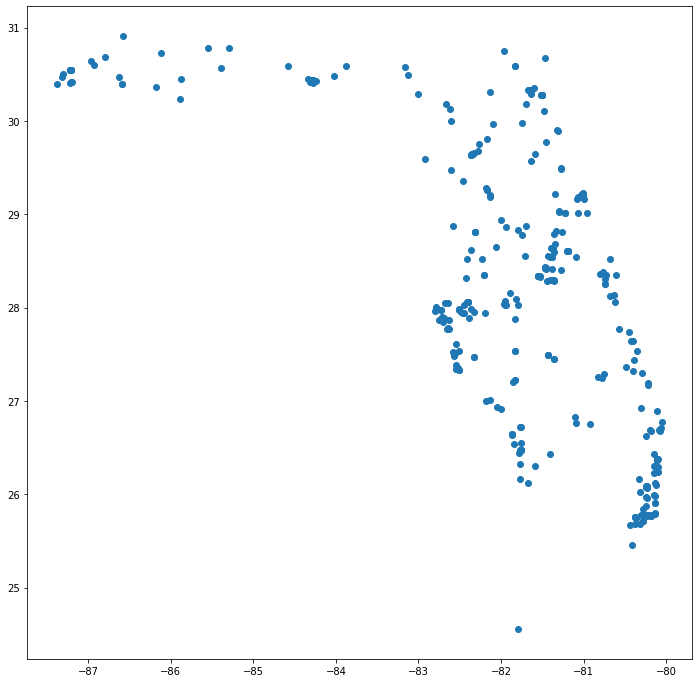

In [42]:
fl_civic.plot(figsize=(14,12))

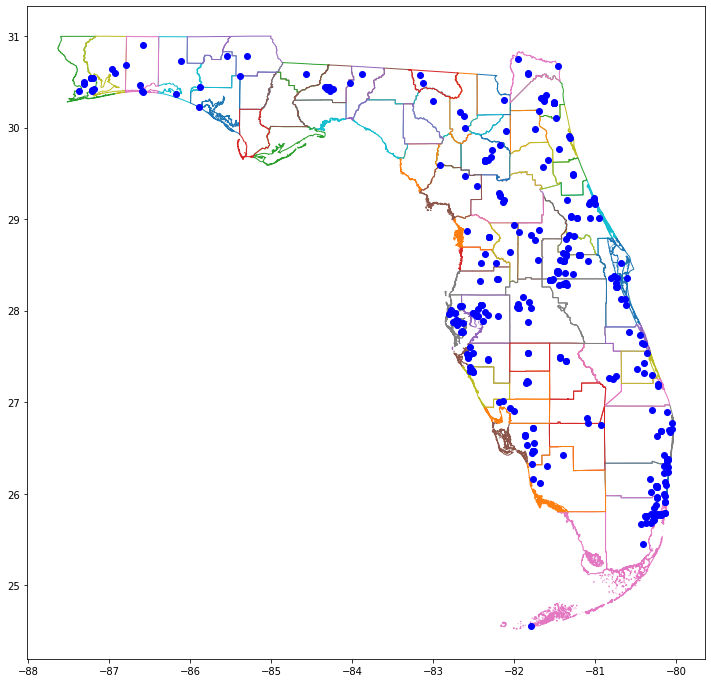

In [43]:
# Plotting multiple layers
fig, ax = plt.subplots(figsize=(14, 12))
fl_counties.plot(ax=ax, facecolor="none", edgecolor='black', column='NAME')
fl_civic.plot(ax=ax, color='blue')

In [44]:
# https://gis.stackexchange.com/questions/367496/plot-a-circle-with-a-given-radius-around-points-on-map-using-python

In [45]:
fl_civic_hil = join_reducer(fl_civic, fl_hil)

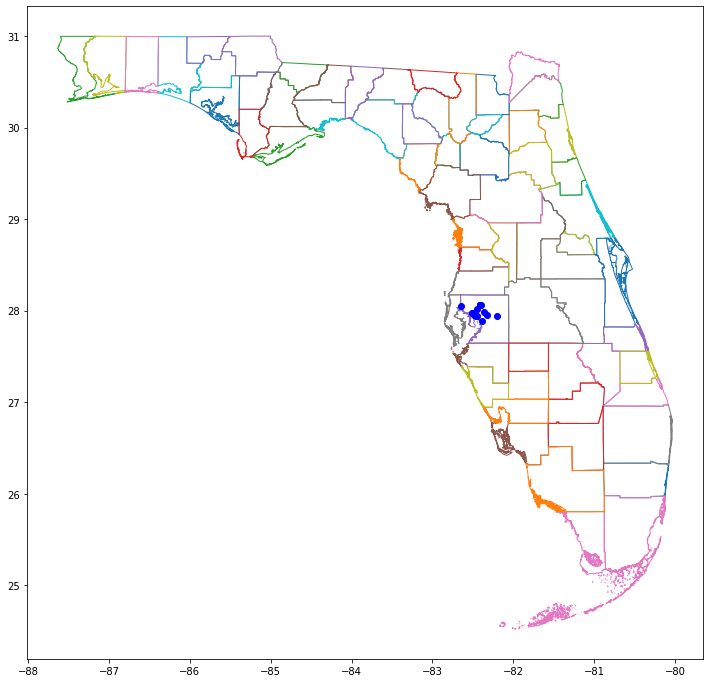

In [46]:
fig, ax = plt.subplots(figsize=(14, 12))
fl_counties.plot(ax=ax, facecolor="none", edgecolor='black', column='NAME')
fl_civic_hil.plot(ax=ax, color='blue')

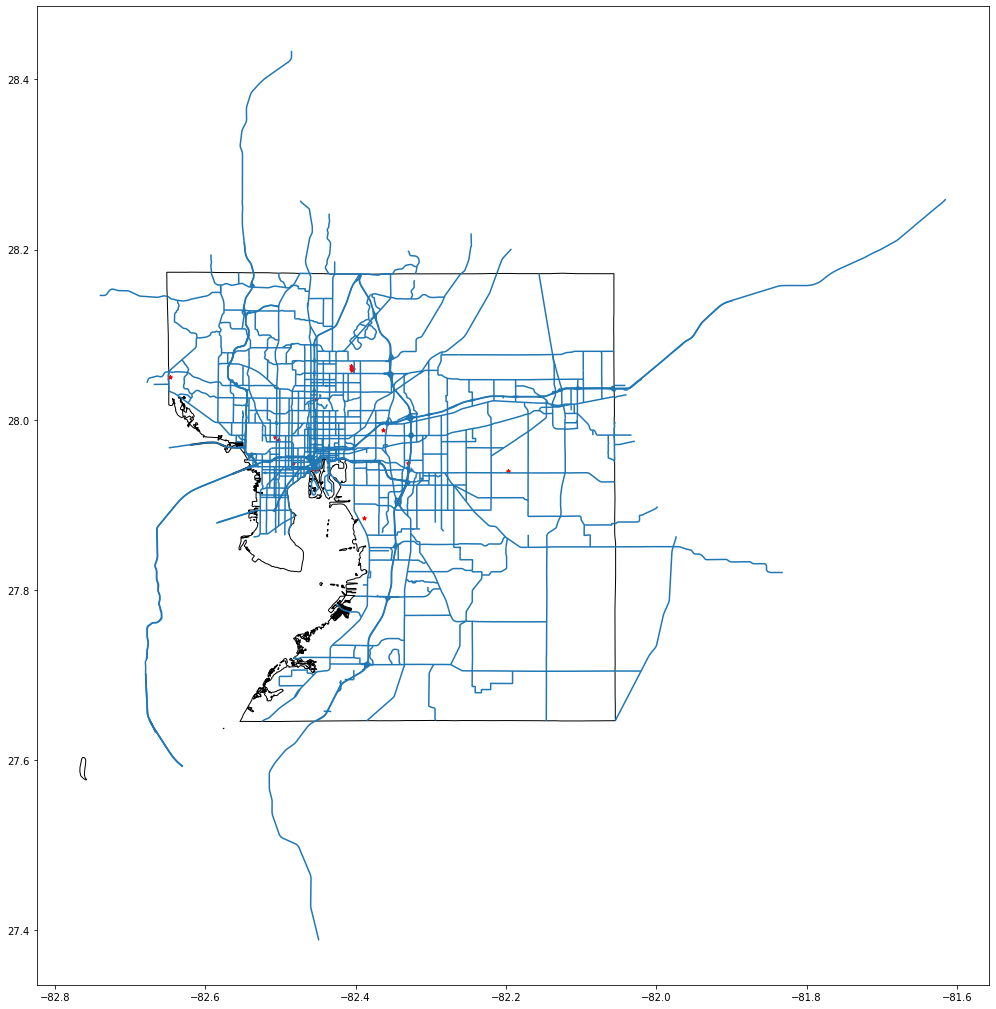

In [47]:
ax = fl_hil.plot(figsize=(20,18), facecolor="none", edgecolor="black")
fl_roads_hil.plot(ax=ax)
fl_civic_hil.plot(marker='*', color='red', markersize=15, ax=ax)

In [48]:
sample_civic_region = sample_location(fl_civic_hil, n=1, buffer=8046.72) # buffer in meters (1 mi = 1609.34 m)

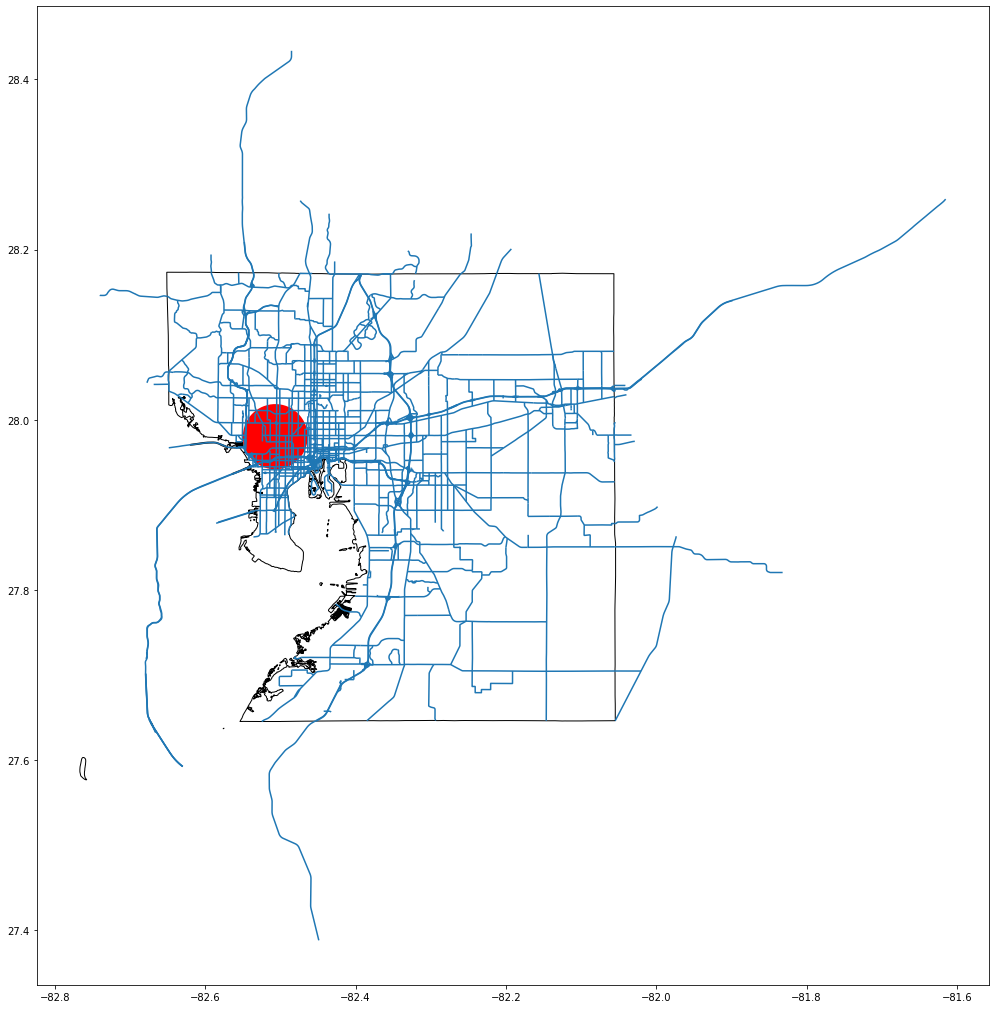

In [49]:
ax = fl_hil.plot(figsize=(20,18), facecolor="none", edgecolor="black")
fl_roads_hil.plot(ax=ax)
sample_civic_region.plot(marker='*', color='red', ax=ax)

In [50]:
sample_civic_df = gpd.GeoDataFrame(sample_civic_region)
sample_civic_df = sample_civic_df.rename(columns={0:'geometry'}).set_geometry('geometry')

In [51]:
fl_roads_hil_sample_civic = join_reducer(fl_roads_hil, sample_civic_df)

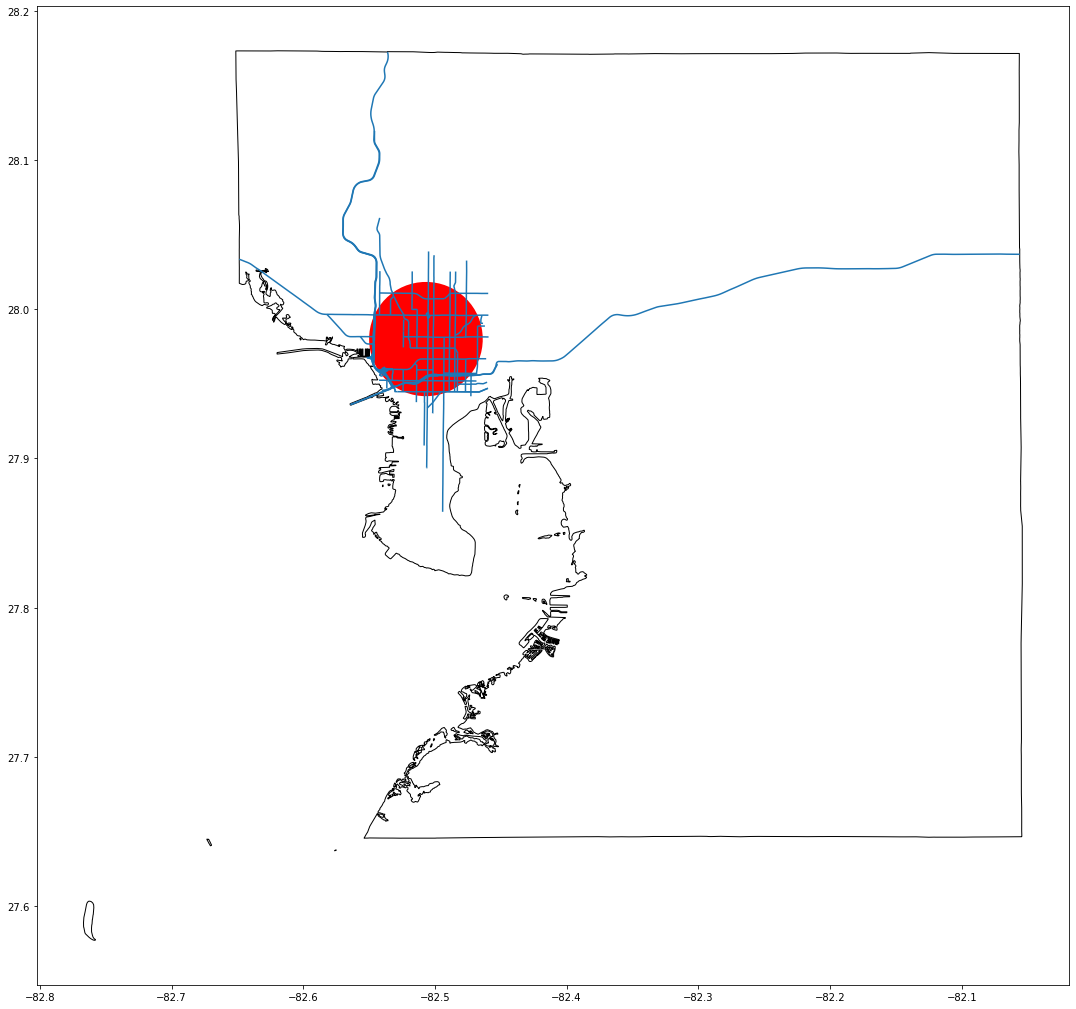

In [52]:
ax = fl_hil.plot(figsize=(20,18), facecolor="none", edgecolor="black")
fl_roads_hil_sample_civic.plot(ax=ax)
sample_civic_region.plot(marker='*', color='red', ax=ax)

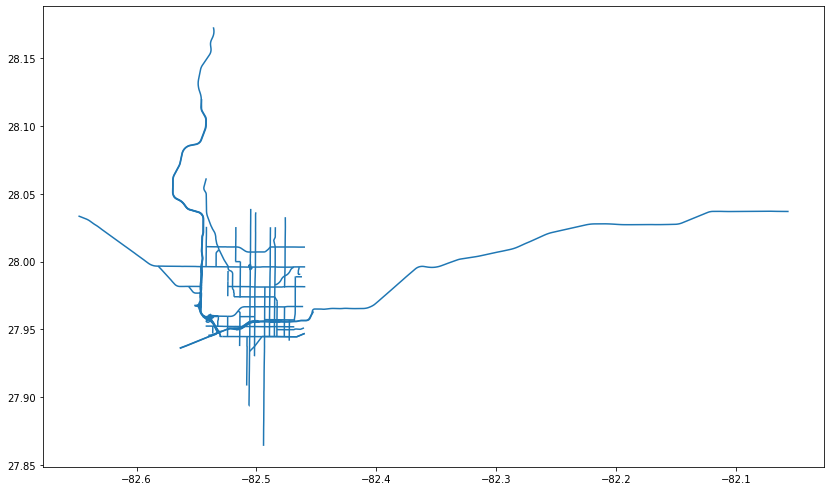

In [53]:
fl_roads_hil_sample_civic.plot(figsize=(14,12))

In [54]:
sample_civic_points = sample_roads(fl_roads_hil_sample_civic, n=5)

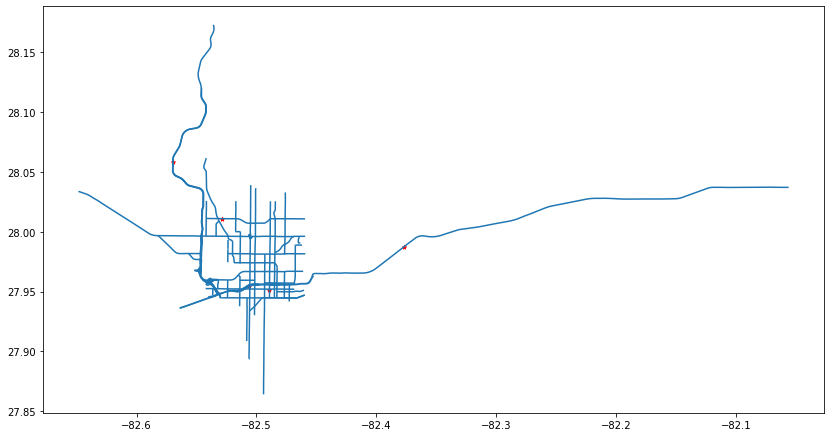

In [55]:
ax = fl_roads_hil_sample_civic.plot(figsize=(14, 12))
sample_civic_points.plot(marker='*', color='red', markersize=15, ax=ax)

In [55]:
# https://gis.stackexchange.com/questions/344983/line-and-polygon-intersection-in-geopandas-python

# lines = streets.geometry.unary_union
# intersection = lines.intersection(buffer.geometry[0])
# type(intersection)
# <class 'shapely.geometry.multilinestring.MultiLineString'>
# # create a GeoDataFrame
# result = geopandas.GeoDataFrame({'geometry':intersection})

In [67]:
lines = fl_roads_hil.geometry.unary_union

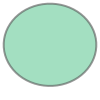

In [68]:
sample_civic_df.geometry[0]

In [69]:
intersection = lines.intersection(sample_civic_df.geometry[0])

In [70]:
type(intersection)

shapely.geometry.multilinestring.MultiLineString

In [72]:
output = gpd.GeoDataFrame({'geometry':intersection})

In [73]:
output

,geometry
0,"LINESTRING (-82.54831 27.97681, -82.54870 27.9..."
1,"LINESTRING (-82.54995 27.98170, -82.54737 27.9..."
2,"LINESTRING (-82.54733 27.97061, -82.54786 27.9..."
3,"LINESTRING (-82.54689 27.97691, -82.54704 27.9..."
4,"LINESTRING (-82.54831 27.97670, -82.54752 27.9..."
...,...
472,"LINESTRING (-82.46764 27.98158, -82.46764 27.9..."
473,"LINESTRING (-82.46764 27.98158, -82.46715 27.9..."
474,"LINESTRING (-82.46753 27.98881, -82.46748 27.9..."
475,"LINESTRING (-82.46541 27.99065, -82.46538 27.9..."


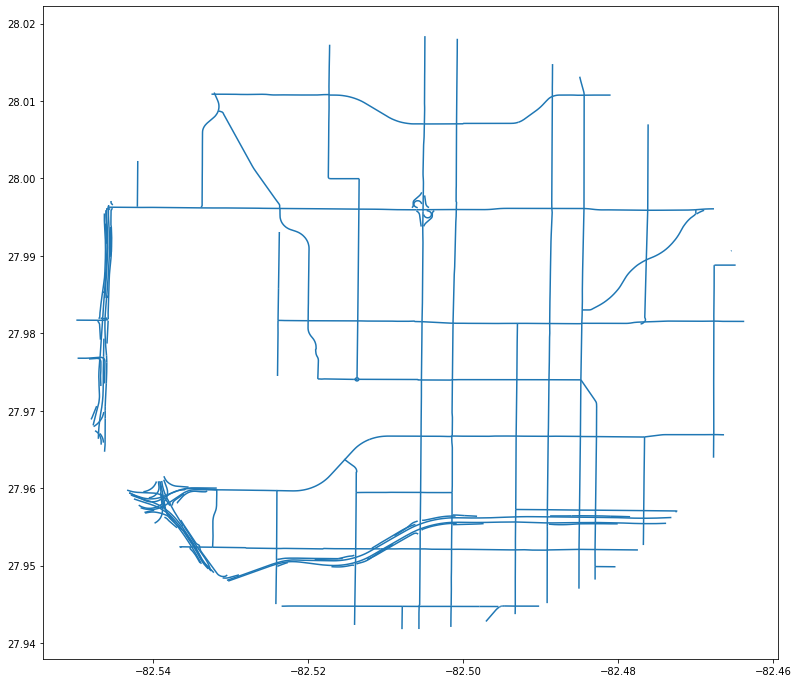

In [74]:
output.plot(figsize=(14, 12))

In [75]:
output_points = sample_roads(output, n=5)
ax = output.plot(figsize=(14, 12))
output_points.plot(marker='*', color='red', markersize=15, ax=ax)

KeyError: ignored